In [1]:
import math
import pandas_datareader as web
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('fivethirtyeight')

In [45]:
from datetime import datetime
startdate = datetime(2010,1,1)
enddate = datetime(2022,1,1)

df= web.DataReader("GOOGL", 'stooq', start=startdate, end=enddate)
df= df.sort_values(by=['Date'])
df

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,15.6740,15.7380,15.6060,15.6690,78248000.0
2010-01-05,15.6795,15.6960,15.5385,15.6000,120188000.0
2010-01-06,15.6465,15.6465,15.1590,15.2065,159148000.0
2010-01-07,15.2350,15.2500,14.8160,14.8525,256572000.0
2010-01-08,14.8000,15.0810,14.7280,15.0505,188972000.0
...,...,...,...,...,...
2021-12-27,147.2560,148.3440,147.1690,147.9060,15984460.0
2021-12-28,148.2360,148.2990,146.0540,146.6870,18254300.0
2021-12-29,146.6440,147.4170,145.6470,146.6550,17787460.0


In [3]:
df.shape

(3021, 5)

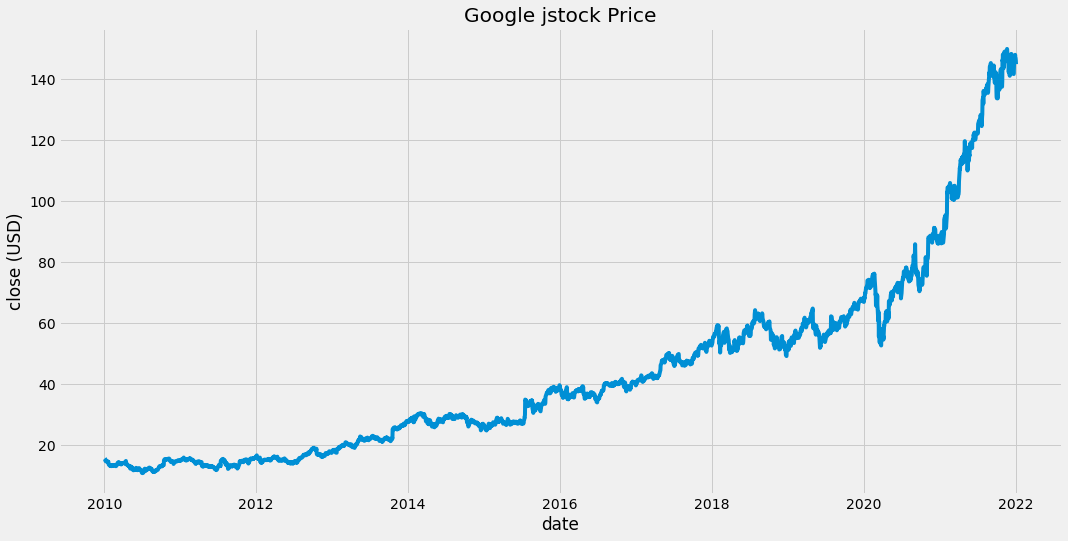

In [4]:
plt.figure(figsize=(16,8))
plt.title('Google jstock Price')
plt.plot(df.Close)
plt.xlabel('date')
plt.ylabel('close (USD)')
plt.show()

In [5]:
data= df.Close
data

Date
2010-01-04     15.6690
2010-01-05     15.6000
2010-01-06     15.2065
2010-01-07     14.8525
2010-01-08     15.0505
                ...   
2021-12-27    147.9060
2021-12-28    146.6870
2021-12-29    146.6550
2021-12-30    146.2000
2021-12-31    144.8520
Name: Close, Length: 3021, dtype: float64

In [6]:
data= df.filter(['Close'])
data

,Close
Date,
2010-01-04,15.6690
2010-01-05,15.6000
2010-01-06,15.2065
2010-01-07,14.8525
2010-01-08,15.0505
...,...
2021-12-27,147.9060
2021-12-28,146.6870
2021-12-29,146.6550


In [7]:
dataset = data.values
dataset

array([[ 15.669 ],
       [ 15.6   ],
       [ 15.2065],
       ...,
       [146.655 ],
       [146.2   ],
       [144.852 ]])

In [8]:
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2417

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(dataset)

scaled_data

array([[0.03431076],
       [0.03381413],
       [0.03098189],
       ...,
       [0.97709017],
       [0.97381528],
       [0.96411297]])

In [10]:
train_data = scaled_data[0:training_data_len , :]
train_data

array([[0.03431076],
       [0.03381413],
       [0.03098189],
       ...,
       [0.34471627],
       [0.35561338],
       [0.34939109]])

In [11]:
x_train = []
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
x_train.shape

(2357, 60)

In [14]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2357, 60, 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2357/2357 [==============================] - 36s 14ms/step - loss: 2.3929e-04


In [17]:
test_data = scaled_data[training_data_len - 60: , :]

In [18]:
x_test = []
y_test = dataset[training_data_len:, :]

for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


In [19]:
x_test = np.array(x_test)

In [20]:
x_test.shape

(604, 60)

In [21]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(604, 60, 1)

In [22]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 9ms/step


In [23]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

3.225404604880226

C:\Users\prasa\AppData\Local\Temp\ipykernel_174948\2661393826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']= predictions


<function matplotlib.pyplot.show(close=None, block=None)>

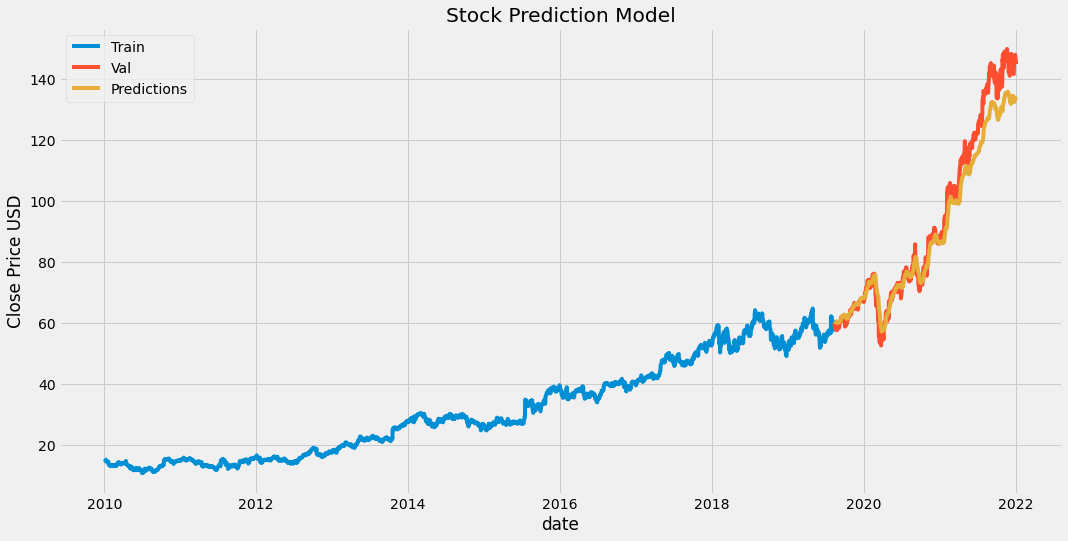

In [24]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions']= predictions

plt.figure(figsize=(16,8))
plt.title('Stock Prediction Model')
plt.xlabel('date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show

In [25]:
valid

,Close,Predictions
Date,,
2019-08-12,58.7250,60.577339
2019-08-13,59.8365,60.506786
2019-08-14,58.2125,60.549103
2019-08-15,58.4660,60.430283
2019-08-16,58.9605,60.296162
...,...,...
2021-12-27,147.9060,133.107559
2021-12-28,146.6870,133.680847
2021-12-29,146.6550,134.052994


In [28]:
google_quote = web.DataReader("GOOGL", 'stooq', start=startdate, end=enddate)
google_quote= google_quote.sort_values(by=['Date'])

new_df = google_quote.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = scaler.transform(last_60_days)

X_test=[]

X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

1/1 [==============================] - 0s 26ms/step
[[134.23657]]


In [44]:
google_quote2 = web.DataReader("GOOGL", 'stooq', start='2022-1-2', end='2022-1-3')
print(google_quote2.Close)

Date
2022-01-03    144.992
Name: Close, dtype: float64
